In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict
import shutil
from tqdm import tqdm


In [57]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    print(xf, yf)
#         coords[:, 1] *= yf
#         coords[:, 0] *= xf
#         coords_int = np.round(coords).astype(np.int32)
#         return coords_int

def _convert_coordinates(geometry, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax

    geometry_out = shapely.affinity.affine_transform(geometry, [xf,0,0,yf,0,0])
    return geometry_out
    
def _plot_mask_from_wkt(raster_img_size, geometry, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if geometry is None:
        return img_mask
    perim_list = []
    interior_list = []
    for k in range(len(geometry)):
        poly = geometry[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = np.round(perim).astype(np.int32)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = np.round(interior).astype(np.int32)
            interior_list.append(interior_c)
    
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask

def _get_xmax_ymin(self, grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)


def _get_polygon_list(self, wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


def _get_and_convert_contours(self, polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def _plot_mask_from_contours(self, raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


def _generate_mask_for_image_and_class(self, raster_size, imageId, class_type):#grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    grid_sizes_panda = self.grid_sizes
    wkt_list_pandas = self.polygons
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask

In [60]:
class MapObject (object):
    __colors = [[255, 0, 0],
                [255, 143, 143],
                [64, 64, 64],
                [112, 64, 0],
                [3, 59, 0],
                [10, 207, 0],
                [0, 11, 135],
                [0, 21, 252],
                [247, 235, 2],
                [128, 121, 4]]
    def __init__(self, img, polygons = None, poly_grids = None, mask = None, predicted_mask = None, RGB_mask = None):
        '''Creates object that includes img (heigth, width, channels), polygons - dictionary {class:shapely MultipolygonWKT}, corresponding mask (heigth, width, num_classes)'''
        self.img = img
        self.polygons = polygons
        self.mask = mask
        self.predicted_mask = predicted_mask
        self.RGB_mask = None
        self.predicted_RGB_mask = None

    def _plot_mask_from_wkt(self, raster_img_size, geometry, class_value=1):
        img_mask = np.zeros(raster_img_size, np.uint8)
        if geometry is None:
            return img_mask
        perim_list = []
        interior_list = []
        for k in range(len(geometry)):
            poly = geometry[k]
            perim = np.array(list(poly.exterior.coords))
            perim_c = np.round(perim).astype(np.int32)
            perim_list.append(perim_c)
            for pi in poly.interiors:
                interior = np.array(list(pi.coords))
                interior_c = np.round(interior).astype(np.int32)
                interior_list.append(interior_c)

        cv2.fillPoly(img_mask, perim_list, class_value)
        cv2.fillPoly(img_mask, interior_list, 0)
        return img_mask

    def poly2mask(self):
        mask_multi =[]
        h, w, _ = self.img.shape
        for cls in list(self.polygons.keys()):
            mask = self._plot_mask_from_wkt((h, w), self.polygons[cls])
            mask_multi.append(mask)
        mask_multi = np.array(mask_multi)
        mask_multi = np.rollaxis(mask_multi, 0,3)
        self.mask = mask_multi
        return mask_multi
        
    def mask2poly():
        raise NotImplementedError
        
    def get_random_patches(self, quantity, patch_size=(256,256), scale=1, aug=True, random_shear=False):
        # Scaling image with scaling factor (Useful for different classes)
        h,w,_ = self.img.shape
        img = cv2.resize(self.img, (int(h*scale), int(w*scale)))
        mask = cv2.resize(self.mask, (int(h*scale), int(w*scale)))
        h,w,_ = img.shape
        
        # Change size of patch - for augmentation bigger patches
        size = patch_size
        if aug:
            size = (patch_size[0]+patch_size[1],patch_size[0]+patch_size[1])
        assert h>size[0] and w>size[1], 'Patch size should be less than 0,5*image_size if aug=True or image_size if aug=False'
        print(h>size[0] and w>size[1])
        # Deriving of random coordinates
        coords = []
        for i in range (quantity):
            coord_h = random.randint(0, h-size[0])
            coord_w = random.randint(0, w-size[1])
            coords.append((coord_h, coord_w))
        
        # Deriving of raw patches
        raw_img_patches, raw_mask_patches = self._crop(coords, size, img, mask, aug, random_shear)
        
        # Creating final patches with crop of image center with size of patch_size
        img_patches = []
        mask_patches = []
        for raw_img_patch in raw_img_patches:
            h = (raw_img_patch.shape[0] - patch_size[0])//2
            w = (raw_img_patch.shape[1] - patch_size[1])//2
            img_patches.append(raw_img_patch[h:h+patch_size[0], w:w+patch_size[1]])
            
        for raw_mask_patch in raw_mask_patches:
            h = (raw_mask_patch.shape[0] - patch_size[0])//2
            w = (raw_mask_patch.shape[1] - patch_size[1])//2
            mask_patches.append(raw_mask_patch[h:h+patch_size[0], w:w+patch_size[1]]) 
        return img_patches, mask_patches
        
    def get_ordered_patches(self, patch_size=(256,256), scale=1, aug=True, random_shear=True, shear=0.15, padding=False, no_mask = False):
        h,w,_ = self.img.shape
        img = cv2.resize(self.img, (int(h*scale), int(w*scale)))
        if not no_mask:
            mask = cv2.resize(self.mask, (int(h*scale), int(w*scale)))
        print(img.shape)
        shear_int = (int(patch_size[0]*shear),int(patch_size[1]*shear))
        
        # Create reflective padding for aquiring integer number of patches
        if padding:
            h,w,_ = img.shape
            pad_h_1 = (patch_size[0]-shear_int[0]-(h-patch_size[0])%(patch_size[0]-shear_int[0]))//2
            pad_h_2 = (patch_size[0]-shear_int[0]-(h-patch_size[0])%(patch_size[0]-shear_int[0]))//2+(patch_size[0]-shear_int[0]-(h-patch_size[0])%(patch_size[0]-shear_int[0]))%2
            pad_w_1 = (patch_size[1]-shear_int[1]-(w-patch_size[1])%(patch_size[1]-shear_int[1]))//2
            pad_w_2 = (patch_size[1]-shear_int[1]-(w-patch_size[1])%(patch_size[1]-shear_int[1]))//2+(patch_size[1]-shear_int[1]-(w-patch_size[1])%(patch_size[1]-shear_int[1]))%2
            print(pad_h_1,pad_h_2,pad_w_1,pad_w_2)
            img = np.pad(img,((pad_h_1,pad_h_2),(pad_w_1,pad_w_2),(0,0)), 'reflect')
            if not no_mask:
                mask = np.pad(mask,((pad_h_1,pad_h_2),(pad_w_1,pad_w_2),(0,0)), 'reflect')
        
        # Get coordinates of patches
        h,w,_ = img.shape
        coords = []
        n_rows = (h-patch_size[0])//(patch_size[0]-shear_int[0])+1
        n_cols = (w-patch_size[1])//(patch_size[1]-shear_int[1])+1
        for i in range(n_rows):
            for j in range(n_cols):
                coord_h = i*(patch_size[0]-shear_int[0])
                coord_w = j*(patch_size[1]-shear_int[1])
                coords.append((coord_h, coord_w))
        print(img.shape)
        
        # Pad image and mask for geting bigger picture on augmentation step
        if aug:
            img = np.pad(img,((patch_size[1]//2,patch_size[1]//2),(patch_size[0]//2,patch_size[0]//2),(0,0)), 'reflect')
            if not no_mask:
                mask = np.pad(mask,((patch_size[1]//2,patch_size[1]//2),(patch_size[0]//2,patch_size[0]//2),(0,0)), 'reflect')
        # Get patches
        if aug:
            if not no_mask:
                raw_img_patches, raw_mask_patches = self._crop(coords, (patch_size[0]+patch_size[1],patch_size[0]+patch_size[1]),
                                     img, mask=mask, random_shear=random_shear, aug=aug)
            else:
                raw_img_patches, raw_mask_patches = self._crop(coords, (patch_size[0]+patch_size[1],patch_size[0]+patch_size[1]),
                                     img, random_shear=random_shear, aug=aug)
        else:
            if not no_mask:
                raw_img_patches, raw_mask_patches = self._crop(coords, (patch_size[0],patch_size[1]),
                                     img, mask=mask, random_shear=random_shear, aug=aug)
            else:
                raw_img_patches, raw_mask_patches = self._crop(coords, (patch_size[0],patch_size[1]),
                                     img, random_shear=random_shear, aug=aug)
        print(len(coords)) 
        print('____', mask.shape)
        
        # Deriving centers of images and masks with the size=patch_size
        img_patches = []
        mask_patches = []
        for raw_img_patch in raw_img_patches:
            h = (raw_img_patch.shape[0] - patch_size[0])//2
            w = (raw_img_patch.shape[1] - patch_size[1])//2
            img_patches.append(raw_img_patch[h:h+patch_size[0], w:w+patch_size[1]])
            
        for raw_mask_patch in raw_mask_patches:
            h = (raw_mask_patch.shape[0] - patch_size[0])//2
            w = (raw_mask_patch.shape[1] - patch_size[1])//2
            mask_patches.append(raw_mask_patch[h:h+patch_size[0], w:w+patch_size[1]]) 
        return img_patches, mask_patches
    
    def _augmentation(self, img, mask = None, rotation = True, mirror = True, zoom = True):
        img_out = img
        mask_out = mask
        # Mirror augmentation
        if mirror == True:
            if random.uniform(0, 1) > 0.5:
                img_out = img_out[::-1]
                if mask_out is not None:
                    mask_out = mask_out[::-1]
            if random.uniform(0, 1) > 0.5:
                img_out = img_out[:, ::-1]
                if mask_out is not None:
                    mask_out = mask_out[:, ::-1]
        # Rotation augmentaion
        if rotation == True:
            n = random.randint(0,3)
            img_out = np.rot90(img_out, n)
            if mask_out is not None:
                mask_out = np.rot90(mask_out, n)
        # Scale augmentaion
        if zoom == True:
            resize_factor = random.uniform(0.8, 1.2)
            h_img, w_img, _ = img_out.shape
            img_out = cv2.resize(img_out, (int(h_img*resize_factor),int(w_img*resize_factor)))
            if mask_out is not None:
                h_msk, w_msk, _ = mask_out.shape 
                mask_out = cv2.resize(mask_out, (int(h_msk*resize_factor), int(w_msk*resize_factor)))
            
        return img_out, mask_out
        
    def _crop(self, coords, size, img, mask=None, aug = True, random_shear = True):
        '''Function for creating crops from image with coordinates'''
        img_patches = []
        mask_patches = []
        h, w, _ = img.shape
        print(img.shape)
        for coord in coords:
            h_1 = coord[0] 
            h_2 = h_1+size[0]
            w_1 = coord[1]
            w_2 = w_1+size[1] 
            if random_shear:
                d_h = int(random.uniform(-0.1, 0.1)*size[0] )
                d_w = int(random.uniform(-0.1, 0.1)*size[1])   
                h_1+=d_h
                h_2+=d_h
                w_1+=d_w
                w_2+=d_w
            h_1 = np.clip (h_1, 0, h-size[0])
            h_2 = np.clip (h_2, 0+size[0], h)
            w_1 = np.clip (w_1, 0, w-size[1])
            w_2 = np.clip (w_2, 0+size[1], w)
            img_patch = img[h_1:h_2,w_1:w_2]
            
            #print(img_patch.shape)
            
            if mask is not None:
                mask_patch = mask[h_1:h_2,w_1:w_2]
                if aug:
                    img_patch, mask_patch = self._augmentation(img_patch, mask_patch)
                mask_patches.append(mask_patch)
            else:
                if aug:
                    img_patch, _ = self._augmentation(img_patch)
            img_patches.append(img_patch)
            
        return img_patches, mask_patches
        
    def plot_RGB_mask(self):
        h, w, n_cls = self.mask.shape
        cls_pixels = []
        for cls in range (n_cls):
            cls_pixels.append(np.sum(self.mask[:,:,cls]))
        indices = np.linspace(0, n_cls-1, n_cls).astype(int)
        indices_sorted = [x for _,x in sorted(zip(cls_pixels,indices), reverse = True)]
        RGB_mask = np.ones((h,w,3), dtype='uint8')*255
        for ind in indices_sorted:
            RGB_mask[self.mask[:,:,ind].astype(bool)] = np.array(self.__colors[ind])
        self.RGB_mask = RGB_mask
        return RGB_mask
    
    def plot_predicted_RGB_mask(self):
        h, w, n_cls = self.predicted_mask.shape
        cls_pixels = []
        for cls in range (n_cls):
            cls_pixels.append(np.sum(self.predicted_mask[:,:,cls]))
        indices = np.linspace(0, n_cls-1, n_cls).astype(int)
        indices_sorted = [x for _,x in sorted(zip(cls_pixels,indices), reverse = True)]
        RGB_mask = np.ones((h,w,3), dtype='uint8')*255
        for ind in indices_sorted:
            RGB_mask[self.predicted_mask[:,:,ind].astype(bool)] = np.array(self.__colors[ind])
        self.RGB_predicted_mask = RGB_mask
        return RGB_mask
        
    def stich_mask_patches():
        raise NotImplementedError
        
    def show(self):
        if self.img is not None:
            tiff.imshow(self.img)
            plt.show()
        if self.RGB_mask is not None:
            tiff.imshow(self.RGB_mask)
            plt.show()
    
    def compare_masks(self):
        if self.predicted_RGB_mask is not None:
            tiff.imshow(self.predicted_RGB_mask)
            plt.show()
            tiff.imshow(self.RGB_mask)
            plt.show()
        else:
            print('There is not predicted mask!')
            
        
    
class DSTLDataset(object):
    def __init__(self):
        raise NotImplementedError
    
    def generate_patches():
        raise NotImplementedError
    
    def statistics():
        raise NotImplementedError
        
    def plot_statistics():
        raise NotImplementedError
        
    def _form_dictionary_for_wkt_classes():
        mask_wkt = DF[DF.ImageId == img_id]
        mask_wkt = mask_wkt[mask_wkt.ClassType == 1]
        mask_wkt = mask_wkt.MultipolygonWKT.values[0]
        mask_raw = wkt_loads(mask_wkt)
        mask_raw = shapely.affinity.affine_transform(mask_raw, [xf,0,0,yf,0,0])

    

In [67]:
a = DSTLDataset()

TypeError: __init__() takes 0 positional arguments but 1 was given

In [2]:
N_Cls = 10
inDir = 'Dataset/DSTL'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
img_id = '6140_1_2'

In [47]:
_convert_coordinates_to_raster(1, [H,W], [Xmax, Ymax])

370269.41808 -370243.395862


In [5]:
masks_dict = {}
for cls in DF.ClassType.unique():
    mask_wkt = DF[DF.ImageId == img_id]
    mask_wkt = mask_wkt[mask_wkt.ClassType == cls]
    mask_wkt = mask_wkt.MultipolygonWKT.values[0]
    mask_raw = wkt_loads(mask_wkt)
    mask_raw = shapely.affinity.affine_transform(mask_raw, [xf,0,0,yf,0,0])
    masks_dict[cls] = mask_raw

# print(list(mask_raw[0].exterior.coords))
# print('\n')
# mask_raw = shapely.affinity.affine_transform(mask_raw, [xf,0,0,yf,0,0])
# print(list(mask_raw[0].exterior.coords))
# mask_raw[0]

# mask = _plot_mask_from_wkt([H,W], mask_raw)
# plt.imshow(mask)
# plt.show()
# masks_dict

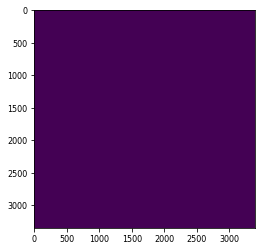

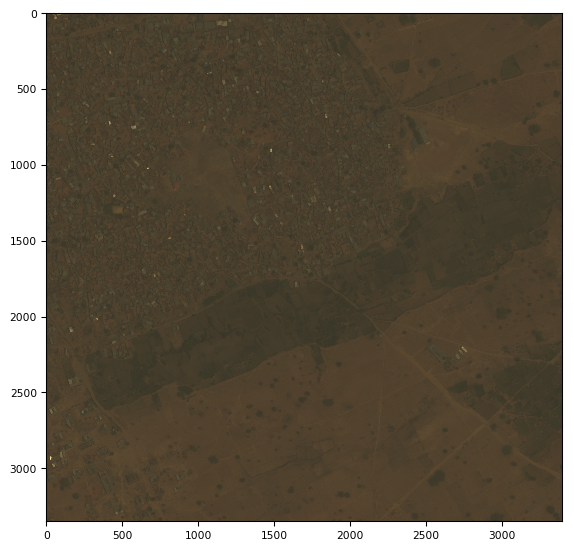

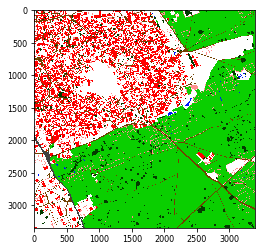

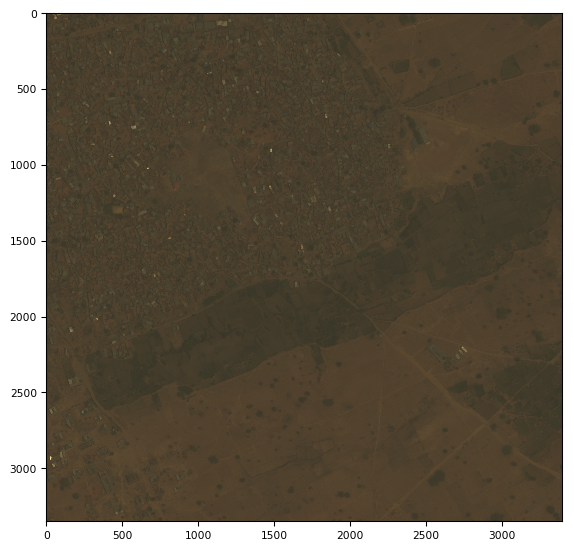

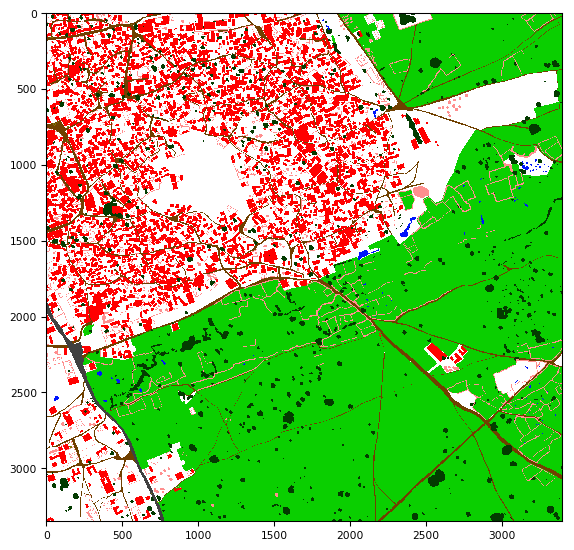

In [8]:
img_ra = np.rollaxis(img, 0,3)
test = MapObject(img_ra, masks_dict)
test.poly2mask()
test.mask.shape
plt.imshow(test.mask[:,:,6])
plt.show()
test.show()
mask_RGB = test.plot_RGB_mask()
plt.imshow(mask_RGB)
plt.show()
test.show()

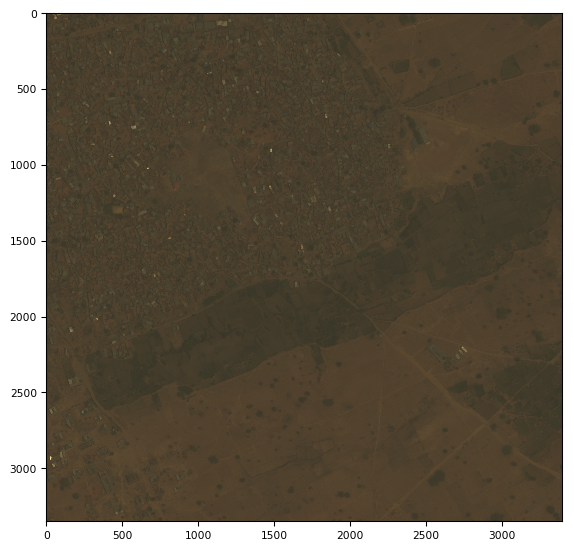

0.009169
-0.00904
370269.41808 -370243.395862


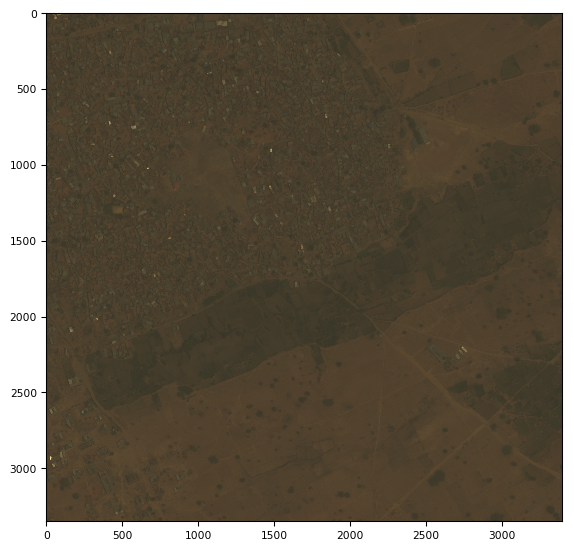

In [4]:
img = tiff.imread('Dataset/DSTL/three_band/6140_1_2.tif')
tiff.imshow(img)
plt.show()

_,H,W = img.shape
Xmax, Ymax = GS[GS.ImageId == img_id].iloc[0,1:3]
print(Xmax)
print(Ymax)
W1 = 1.0 * W * W / (W + 1)
H1 = 1.0 * H * H / (H + 1)
xf = W1 / Xmax
yf = H1 / Ymax
print(xf, yf)
img_c8 = (np.round(img/256*256)).astype(np.uint8)
img_c8 = np.rollaxis(img_c8, 0, 3)
tiff.imshow(img_c8)
plt.show()
img_c8[1,1,:]
tiff.imsave('test.tif', img_c8)

In [ ]:
arr = np.array([[[1,2,3],[1,2,3]],[[4,5,6],[4,5,6]],[[7,8,9],[7,8,9]]])
arr = np.rollaxis(arr, 1,3)
mask = np.array([[0,0,1],[0,0,0],[1,0,0]]).astype(bool)
arr[mask] =np.array([10,11])
arr

In [216]:
arr = np.array([[[1,2,3],[1,2,3]],[[4,5,6],[4,5,6]]])
arr = np.rollaxis(arr, 1,3)
np.rot90(arr)[:,:,0]

array([[3, 6],
       [2, 5],
       [1, 4]])

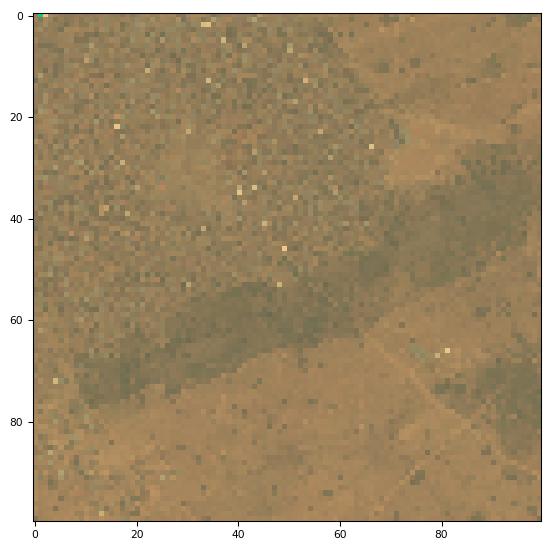

In [35]:
img_rolled = np.rollaxis(img, 0, 3)
img_rolled = cv2.resize(img_rolled,(100,100))
tiff.imshow(img_rolled)
plt.show()


(3348, 3396, 3)


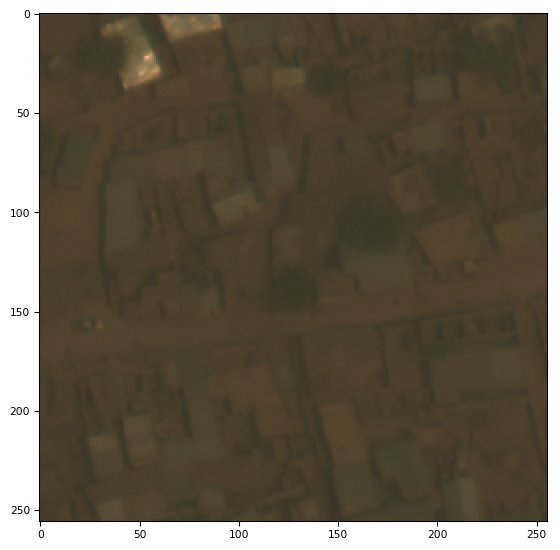

(256, 256, 3)


/home/user/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


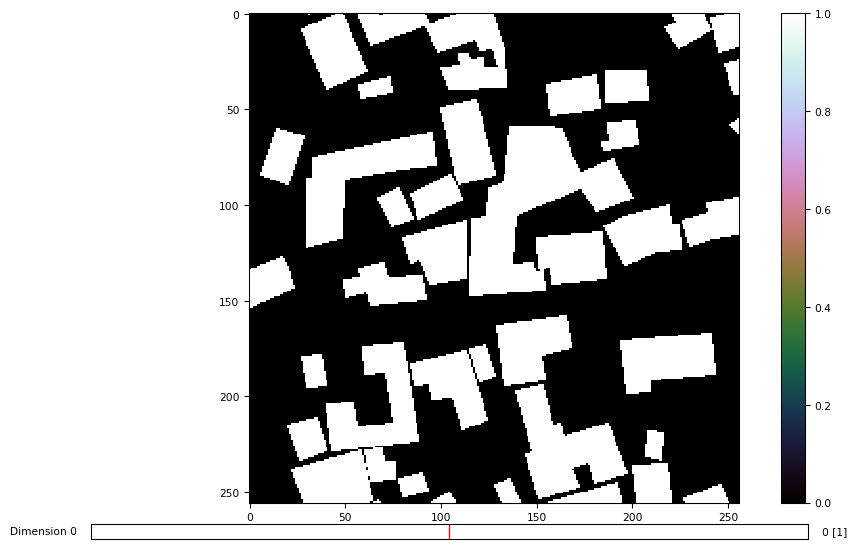

(256, 256, 10)


In [232]:
img_ra = np.rollaxis(img, 0,3)
test = MapObject(img_ra, masks_dict)
test.poly2mask()
img_patch, mask_patch = test._crop([(10,10), (10,10000), (10,10), ], (256,256),test.img, test.mask, aug= False, random_shear=False)
img_patch[0].shape
# for patch in img_patch:
#     tiff.imshow(patch)
#     plt.show()
#     print(patch.shape)
tiff.imshow(img_patch[0])
plt.show()
print(img_patch[0].shape)
tiff.imshow(mask_patch[0][:,:,0])
plt.show()
print(mask_patch[0].shape)

(339, 334, 3)
(339, 334, 3)
(339, 334, 3)
1
____ (339, 334, 10)


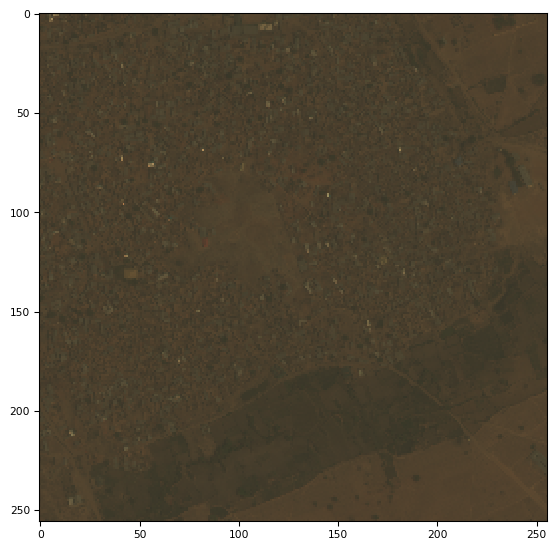

/home/user/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


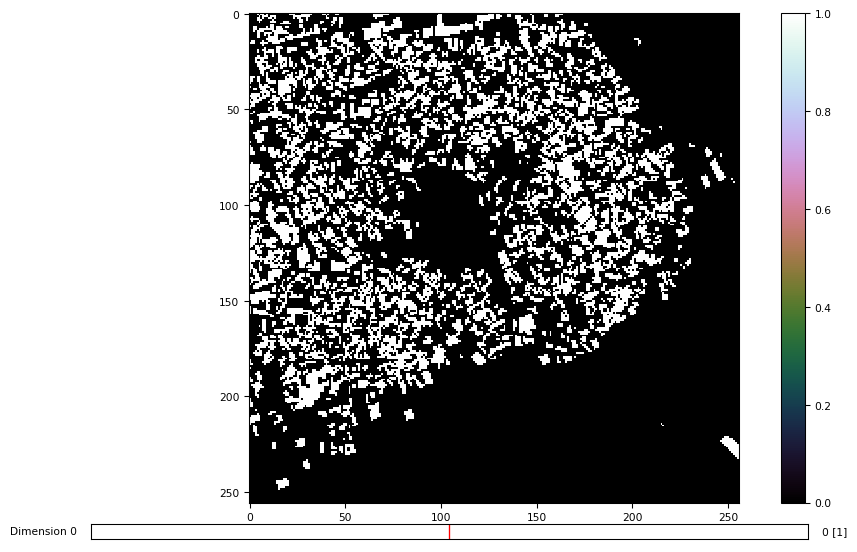

IndexError: list index out of range

In [61]:
img_ra = np.rollaxis(img, 0,3)
test = MapObject(img_ra, masks_dict)
test.poly2mask()
patches, mask_patches = test.get_ordered_patches(shear=0, scale = 0.1, random_shear=False, aug=False)
for i in range(5):
    tiff.imshow(patches[i])
    plt.show()
    tiff.imshow(mask_patches[i][:,:,0])
    plt.show()

True
(339, 334, 3)
10


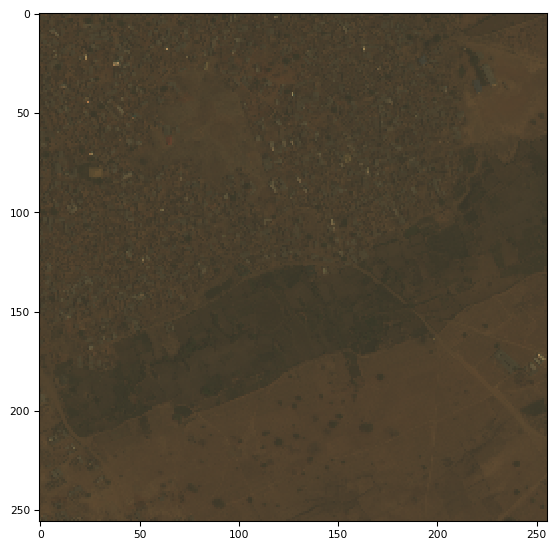

/home/user/anaconda3/envs/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


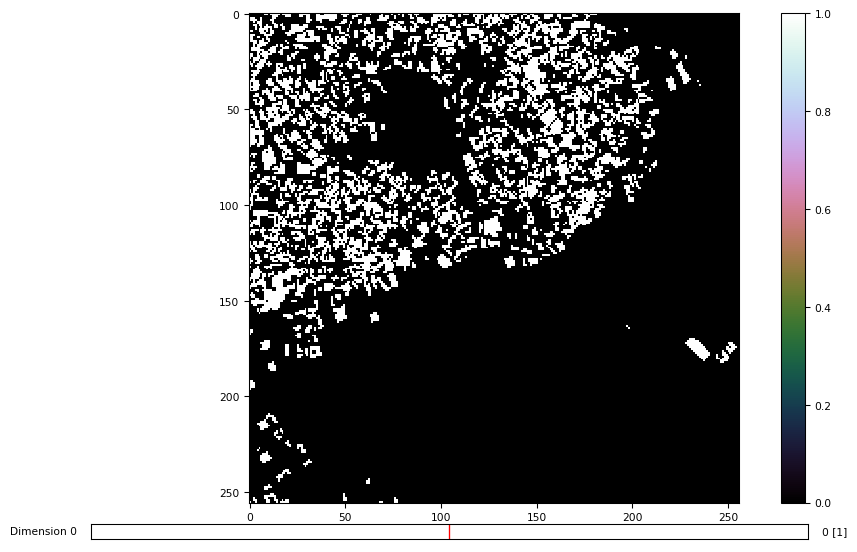

In [64]:
img_patches, mask_patches = test.get_random_patches(10, scale=0.1, aug = False)
print(len(img_patches))
tiff.imshow(img_patches[0])
plt.show()
tiff.imshow(mask_patches[0][:,:,0])
plt.show()

In [57]:
assert True and True, 'asd'